<a href="https://colab.research.google.com/github/rizkarifda/Data-Analysis-Using-Python-Programming/blob/master/Supplier_Segmentation_Using_K_Means_and_RFM_Method_by_Rizka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install --upgrade xlrd
!pip install --upgrade pandas==1.2.0
import numpy as np
import pandas as pd
import xlrd as xl

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go
import datetime as dt
!pip install feature-engine
import feature_engine
from feature_engine.outliers import Winsorizer
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 5.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 36.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1dTYnTieQZJRqK72lN8jor6Kpn6rnfDXh"})
downloaded.GetContentFile('pesan_barang1.xls')

In [ ]:
dataset = pd.read_excel('pesan_barang1.xls')
dataset.head()

,transaction_id,transaction_date,merchant_name,supplier_name,quantity,total_value,region,referral_code,discount_awantunai_(%)
0,981ab3dc-fb15-47ce-bfae-6d90375a4964,2022-01-15,Wilfred Bowman,Grosir J,52,1444386,Jakarta Barat,NaN,0
1,dff200f1-535c-4666-8289-749726aa0330,2022-03-15,Clara Mcdonald,Grosir VV,54,9256177,Serang,yes,0
2,747afe0b-2a20-4e04-b320-61c06246fbef,2022-01-27,Darrell Sherman,Grosir Q,33,174716,Jawa Timur,yes,0
3,91402a9f-b6a8-4aed-9fad-532ad8228a07,2022-04-04,Max Wilkerson,Grosir J,51,1020858,Jakarta Barat,yes,0
4,18b5d26f-cbde-4b56-9f06-f63ad7385597,2022-04-16,Sarah French,Grosir WW,62,5923529,Bali Nusa Tenggara,NaN,0


In [ ]:
dataset.shape

(2000, 9)

DATA PREPARATION

In [ ]:
def summary(dataset, pred=None):
  obs = dataset.shape[0]
  types = dataset.dtypes
  counts = dataset.apply(lambda x: x.count())
  min = dataset.min()
  uniques = dataset.apply(lambda x: x.unique().shape[0])
  nulls = dataset.apply(lambda x: x.isnull().sum())
  print('Data shape:', dataset.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(dataset)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (2000, 9)
___________________________
Data types:
object            5
int64             3
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
referral_code,object,418,2,1582,NaN
discount_awantunai_(%),int64,2000,11,0,0
merchant_name,object,2000,399,0,Aaron Flores
quantity,int64,2000,72,0,1
region,object,2000,14,0,Bali Nusa Tenggara
supplier_name,object,2000,52,0,Grosir A
total_value,int64,2000,1999,0,30193
transaction_date,datetime64[ns],2000,103,0,2022-01-01 00:00:00
transaction_id,object,2000,2000,0,0004878a-c344-457c-9ffc-0be546d06b90


In [ ]:
dataset.describe()

,quantity,total_value,discount_awantunai_(%)
count,2000.000000,2.000000e+03,2000.000000
mean,22.019500,1.038881e+07,2.187000
std,14.911516,1.889888e+07,2.716012
min,1.000000,3.019300e+04,0.000000
25%,10.000000,5.991930e+05,0.000000
50%,20.000000,1.988338e+06,0.000000
75%,31.000000,7.692996e+06,5.000000
max,72.000000,7.799228e+07,10.000000


In [ ]:
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'], format = "%d-%m-%Y %H:%M")
dataset.head()

,transaction_id,transaction_date,merchant_name,supplier_name,quantity,total_value,region,referral_code,discount_awantunai_(%)
0,981ab3dc-fb15-47ce-bfae-6d90375a4964,2022-01-15,Wilfred Bowman,Grosir J,52,1444386,Jakarta Barat,NaN,0
1,dff200f1-535c-4666-8289-749726aa0330,2022-03-15,Clara Mcdonald,Grosir VV,54,9256177,Serang,yes,0
2,747afe0b-2a20-4e04-b320-61c06246fbef,2022-01-27,Darrell Sherman,Grosir Q,33,174716,Jawa Timur,yes,0
3,91402a9f-b6a8-4aed-9fad-532ad8228a07,2022-04-04,Max Wilkerson,Grosir J,51,1020858,Jakarta Barat,yes,0
4,18b5d26f-cbde-4b56-9f06-f63ad7385597,2022-04-16,Sarah French,Grosir WW,62,5923529,Bali Nusa Tenggara,NaN,0


In [ ]:
dataset.loc[(dataset.total_value<0)]

,transaction_id,transaction_date,merchant_name,supplier_name,quantity,total_value,region,referral_code,discount_awantunai_(%)


In [ ]:
dataset.loc[(dataset.quantity<0)]

,transaction_id,transaction_date,merchant_name,supplier_name,quantity,total_value,region,referral_code,discount_awantunai_(%)


In [ ]:
dataset.isnull().values.any()

True

In [ ]:
dataset.isnull().mean()*100

transaction_id             0.0
transaction_date           0.0
merchant_name              0.0
supplier_name              0.0
quantity                   0.0
total_value                0.0
region                     0.0
referral_code             79.1
discount_awantunai_(%)     0.0
dtype: float64

In [ ]:
dataset.region.value_counts(normalize=True)

Bogor                 0.1365
Jakarta Timur         0.1035
Jakarta Barat         0.0950
Bekasi                0.0935
Jawa Timur            0.0915
Jakarta Utara         0.0895
Tangerang             0.0700
Karawang              0.0680
Sukabumi              0.0600
Serang                0.0550
Bandung               0.0380
Jakarta Selatan       0.0375
Jakarta Pusat         0.0310
Bali Nusa Tenggara    0.0310
Name: region, dtype: float64

In [ ]:
dataset = dataset[dataset.quantity > 0]
dataset = dataset[dataset.total_value > 0]

#Removing the Null values from the data.
dataset = dataset[pd.notnull(dataset['referral_code'])]

In [ ]:
from time import strftime
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])
dataset['transaction_yearmonth'] = dataset['transaction_date'].map(lambda date:100*date.year + date.month)
dataset['Date'] = dataset['transaction_date'].dt.strftime('%Y-%m')

In [ ]:
dataset.isnull().mean()

transaction_id            0.0
transaction_date          0.0
merchant_name             0.0
supplier_name             0.0
quantity                  0.0
total_value               0.0
region                    0.0
referral_code             0.0
discount_awantunai_(%)    0.0
transaction_yearmonth     0.0
Date                      0.0
dtype: float64

In [ ]:
dataset_agg= dataset.groupby("Date").total_value.sum()
dataset_agg

Date
2022-01    1185805070
2022-02    1177468647
2022-03     740738960
2022-04    1333873485
Name: total_value, dtype: int64

In [ ]:
#converting series to dataframe and resetting index, and changing the column name to 'Orders'
dataset_agg=pd.DataFrame(dataset_agg)
dataset_agg=dataset_agg.reset_index()
dataset_agg.head()

,Date,total_value
0,2022-01,1185805070
1,2022-02,1177468647
2,2022-03,740738960
3,2022-04,1333873485


In [ ]:
def plot_df(dataset, x, y, title="", xlabel='Date', ylabel='Total Values', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

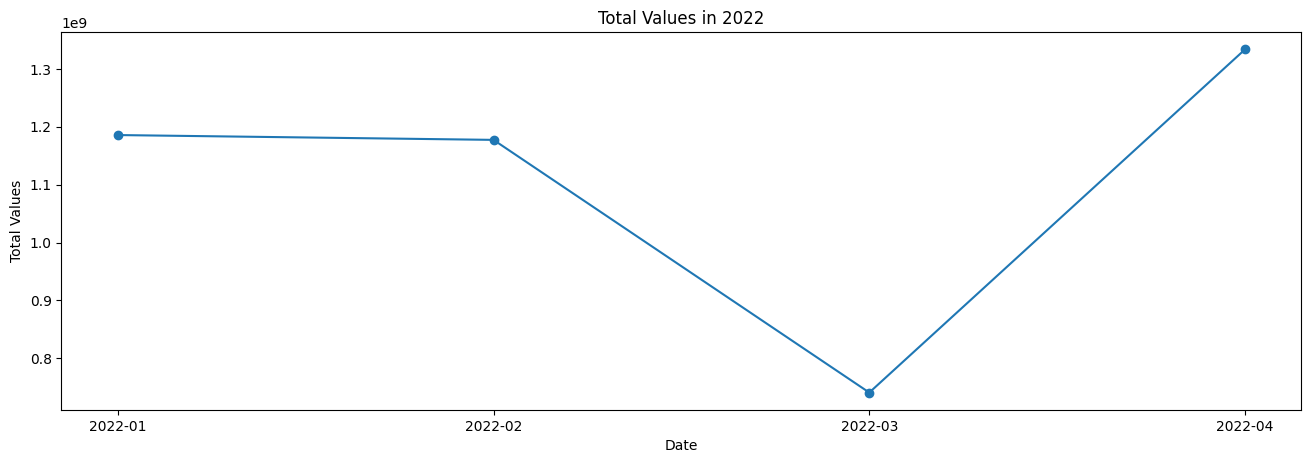

In [ ]:
plot_df(dataset_agg, x=dataset_agg.Date, y=dataset_agg.total_value,title='Total Values in 2022')

RFM ANALYSIS

FREQUENCY

In [ ]:
frequency = dataset.groupby("supplier_name").merchant_name.count()
frequency = frequency.reset_index()
frequency.head()

,supplier_name,merchant_name
0,Grosir A,12
1,Grosir AA,6
2,Grosir B,6
3,Grosir BB,10
4,Grosir C,5


In [ ]:
maximum = max(dataset.transaction_date)

In [ ]:
maximum = maximum + pd.DateOffset(days = 1)

In [ ]:
dataset['diff'] = maximum - dataset.transaction_date
dataset.head()

,transaction_id,transaction_date,merchant_name,supplier_name,quantity,total_value,region,referral_code,discount_awantunai_(%),transaction_yearmonth,Date,diff
1,dff200f1-535c-4666-8289-749726aa0330,2022-03-15,Clara Mcdonald,Grosir VV,54,9256177,Serang,yes,0,202203,2022-03,47 days
2,747afe0b-2a20-4e04-b320-61c06246fbef,2022-01-27,Darrell Sherman,Grosir Q,33,174716,Jawa Timur,yes,0,202201,2022-01,94 days
3,91402a9f-b6a8-4aed-9fad-532ad8228a07,2022-04-04,Max Wilkerson,Grosir J,51,1020858,Jakarta Barat,yes,0,202204,2022-04,27 days
10,ab9e9cf6-d93b-42fc-880e-04bb9551ff3e,2022-04-09,Elijah Butler,Grosir J,50,281974,Jakarta Barat,yes,6,202204,2022-04,22 days
15,b9d05dcc-ac7c-4734-942b-4f65750ef9ca,2022-02-23,Jeffrey Martin,Grosir BB,54,2920111,Jakarta Utara,yes,0,202202,2022-02,67 days


RECENCY

In [ ]:
NOW = dt.date(2022,4,30)
dataset['transaction_date'] = pd.DatetimeIndex(dataset.transaction_date).date

In [ ]:
Recency = dataset.groupby(['supplier_name'],as_index=False)['transaction_date'].max()
Recency.columns = ['supplier_name','Last_Transaction_Date']

Recency['Recency'] = Recency.Last_Transaction_Date.apply(lambda x:(NOW - x).days)
Recency.drop(columns=['Last_Transaction_Date'],inplace=True)
Recency.head()

,supplier_name,Recency
0,Grosir A,18
1,Grosir AA,5
2,Grosir B,9
3,Grosir BB,21
4,Grosir C,29


MONETARY

In [ ]:
monetary = dataset.groupby("supplier_name").total_value.sum()
monetary = monetary.reset_index()
monetary.head()  

,supplier_name,total_value
0,Grosir A,125697926
1,Grosir AA,13533387
2,Grosir B,15769169
3,Grosir BB,65280156
4,Grosir C,76137948


FREQUENCY

In [ ]:
RFM1 = frequency.merge(Recency, on = "supplier_name", how = "inner")
RFM1.columns = ['supplier_name','Frequency','Recency']
RFM1.head()

,supplier_name,Frequency,Recency
0,Grosir A,12,18
1,Grosir AA,6,5
2,Grosir B,6,9
3,Grosir BB,10,21
4,Grosir C,5,29


In [ ]:
RFM = RFM1.merge(monetary, on = "supplier_name", how = "inner")
RFM.columns = ['supplier_name','Frequency','Recency','Monetary']
RFM.tail()

,supplier_name,Frequency,Recency,Monetary
35,Grosir WW,17,4,92880680
36,Grosir X,5,16,14840325
37,Grosir XX,10,3,126122157
38,Grosir Y,1,3,72099747
39,Grosir ZZ,10,17,177267692


Now we split the metrics into segments using quantiles. We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [ ]:
quantiles = RFM.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = RFM.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,supplier_name,Frequency,Recency,Monetary,R_quartile,F_quartile,M_quartile
0,Grosir A,12,18,125697926,4,2,2
1,Grosir AA,6,5,13533387,2,4,4
2,Grosir B,6,9,15769169,3,4,4
3,Grosir BB,10,21,65280156,4,2,3
4,Grosir C,5,29,76137948,4,4,3


Calculating the total RFM score combined

RFM_Score = R_quartile + F_quartile + M_quartile

In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [ ]:
segmented_rfm.head()

,supplier_name,Frequency,Recency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,Grosir A,12,18,125697926,4,2,2,422
1,Grosir AA,6,5,13533387,2,4,4,244
2,Grosir B,6,9,15769169,3,4,4,344
3,Grosir BB,10,21,65280156,4,2,3,423
4,Grosir C,5,29,76137948,4,4,3,443


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [ ]:
segmented_rfm.head()

,supplier_name,Frequency,Recency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,Grosir A,12,18,125697926,4,2,2,422,8
1,Grosir AA,6,5,13533387,2,4,4,244,10
2,Grosir B,6,9,15769169,3,4,4,344,11
3,Grosir BB,10,21,65280156,4,2,3,423,9
4,Grosir C,5,29,76137948,4,4,3,443,11


In [ ]:
segmented_rfm.sample(40)

,supplier_name,Frequency,Recency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
13,Grosir HH,13,24,204572357,4,2,1,421,7
16,Grosir JJ,15,4,119612042,2,2,2,222,6
34,Grosir W,6,39,74796248,4,4,3,443,11
33,Grosir VV,16,15,59992315,3,1,3,313,7
37,Grosir XX,10,3,126122157,2,2,2,222,6
18,Grosir L,18,2,169966391,1,1,1,111,3
36,Grosir X,5,16,14840325,3,4,4,344,11
2,Grosir B,6,9,15769169,3,4,4,344,11
26,Grosir R,5,4,11916887,2,4,4,244,10
30,Grosir U,3,33,7991880,4,4,4,444,12


In [ ]:
print("Best Suppliers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print("Loyal Suppliers: ",len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Good Suppliers: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Lost Suppliers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Suppliers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Suppliers:  5
Loyal Suppliers:  10
Good Suppliers:  10
Lost Suppliers:  3
Lost Cheap Suppliers:  3


In [ ]:
Best_Supplier = segmented_rfm[segmented_rfm['RFM_Segment']=='111']
print("Best Suppliers: ",Best_Supplier['supplier_name'])

Best Suppliers:  15    Grosir J
18    Grosir L
21    Grosir N
25    Grosir Q
32    Grosir V
Name: supplier_name, dtype: object


In [ ]:
Loyal_Supplier = segmented_rfm[segmented_rfm['F_quartile']==1]
print("Loyal Suppliers: ",Loyal_Supplier['supplier_name'])

Loyal Suppliers:  6      Grosir D
9     Grosir EE
15     Grosir J
18     Grosir L
21     Grosir N
25     Grosir Q
29    Grosir TT
32     Grosir V
33    Grosir VV
35    Grosir WW
Name: supplier_name, dtype: object


In [ ]:
Good_Suppliers = segmented_rfm[segmented_rfm['M_quartile']==1]
print("Good Suppliers: ",Good_Suppliers['supplier_name'])

Good Suppliers:  11    Grosir FF
13    Grosir HH
14     Grosir I
15     Grosir J
18     Grosir L
21     Grosir N
25     Grosir Q
29    Grosir TT
32     Grosir V
39    Grosir ZZ
Name: supplier_name, dtype: object


In [ ]:
Lost_Supplier = segmented_rfm[segmented_rfm['RFM_Segment']=='344']
print("Lost Suppliers: ",Lost_Supplier['supplier_name'])

Lost Suppliers:  2      Grosir B
5     Grosir CC
36     Grosir X
Name: supplier_name, dtype: object


In [ ]:
Lost_Cheap_Supplier = segmented_rfm[segmented_rfm['RFM_Segment']=='444']
print("Lost Cheap Suppliers: ",Lost_Cheap_Supplier['supplier_name'])

Lost Cheap Suppliers:  8     Grosir E
23    Grosir P
30    Grosir U
Name: supplier_name, dtype: object


In [ ]:
segmented_rfm['RFM_Score'].unique()

array([ 8, 10, 11,  9,  5, 12,  6,  7,  4,  3])

In [ ]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count',] }).round(1)

Recency Frequency     Monetary      
             mean      mean         mean count
RFM_Score                                     
3             1.4      21.4  265267262.4     5
4             2.0      15.0  206099572.0     1
5             5.0      15.5  148102883.5     4
6             6.6      11.6  137238412.7     7
7             9.8      11.0  114099197.2     4
8            12.5      10.5  139607461.5     2
9            12.7       6.3   62262930.7     3
10            6.2       5.0   23474382.4     5
11           28.0       5.7   41757852.3     6
12           38.0       3.3   20683441.7     3

K-Means Clustering

Reduced Skewness and Normalized the Data

In [ ]:
RFM_norm = RFM.drop("supplier_name", axis=1)
RFM_norm.head()

,Frequency,Recency,Monetary
0,12,18,125697926
1,6,5,13533387
2,6,9,15769169
3,10,21,65280156
4,5,29,76137948


In [ ]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(RFM_norm)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [ ]:
df_rfm_log = windsoriser.transform(RFM_norm)

In [ ]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [ ]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=RFM_norm.columns)
RFM_Table_scaled.head()

,Frequency,Recency,Monetary
0,0.304628,0.563502,0.222019
1,-0.750706,-0.533077,-1.180811
2,-0.750706,-0.195668,-1.152848
3,-0.047150,0.816558,-0.533620
4,-0.926595,1.491376,-0.397822


Finding the optimal number of clusters

In [ ]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

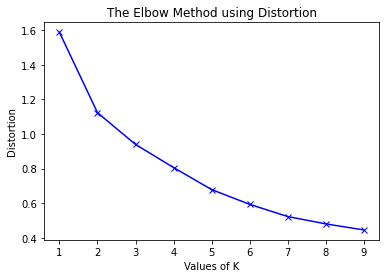

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

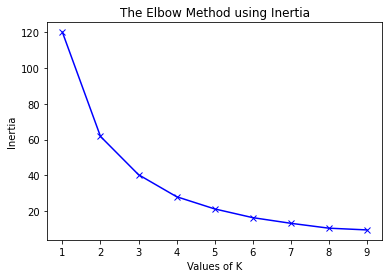

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

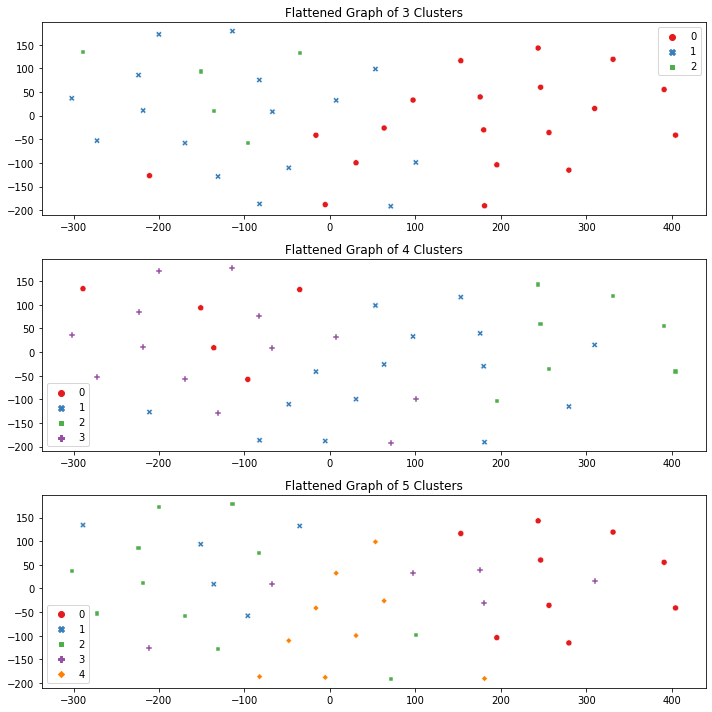

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_norm)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_norm)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_norm)

plt.tight_layout()

In [ ]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM.index, 
                                       columns=RFM.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['supplier_name', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

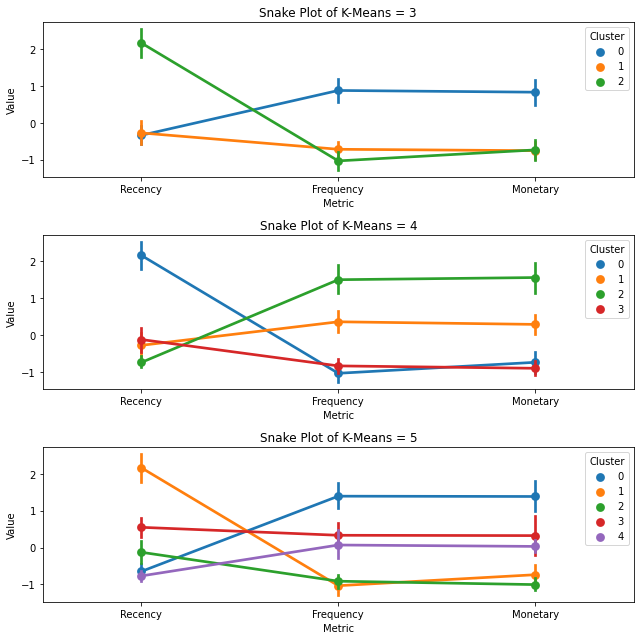

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM)

plt.tight_layout()

From the flattened graphs and the snake plots it is evident that having a cluster value of 5,segments our supplier well. We could also go for higher number of clusters, it completely depends on how the company wants to segment their users.

In [ ]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [ ]:
final = rfm_values(df_rfm_k5)
final.head()

Recency Frequency     Monetary      
           mean      mean         mean count
Cluster                                     
0           4.0      19.0  232028221.0     9
1          44.0       4.0   49183855.0     5
2          10.0       5.0   27778065.0    11
3          18.0      12.0  133919866.0     6
4           2.0      11.0  110514998.0     9

In [ ]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm)

KMeans(max_iter=50, n_clusters=5)

In [ ]:
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['supplier_name','Frequency','Recency','Monetary','ClusterID']
RFM_km.head()

,supplier_name,Frequency,Recency,Monetary,ClusterID
0,Grosir A,12,18,125697926,2
1,Grosir AA,6,5,13533387,0
2,Grosir B,6,9,15769169,0
3,Grosir BB,10,21,65280156,2
4,Grosir C,5,29,76137948,2


In [ ]:
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())
km_clusters_monetary = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Monetary.mean())

In [ ]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_frequency, km_clusters_recency, km_clusters_monetary], axis=1)
df.columns = ["ClusterID", "Recency_mean", "Frequency_mean", "Monetary_mean"]
df.head()

,ClusterID,Recency_mean,Frequency_mean,Monetary_mean
0,0,5.166667,20.250000,2.168618e+07
1,1,14.600000,9.000000,1.820126e+08
2,2,9.400000,10.266667,9.222215e+07
3,3,26.500000,1.000000,2.832583e+08
4,4,16.000000,1.000000,4.076771e+08


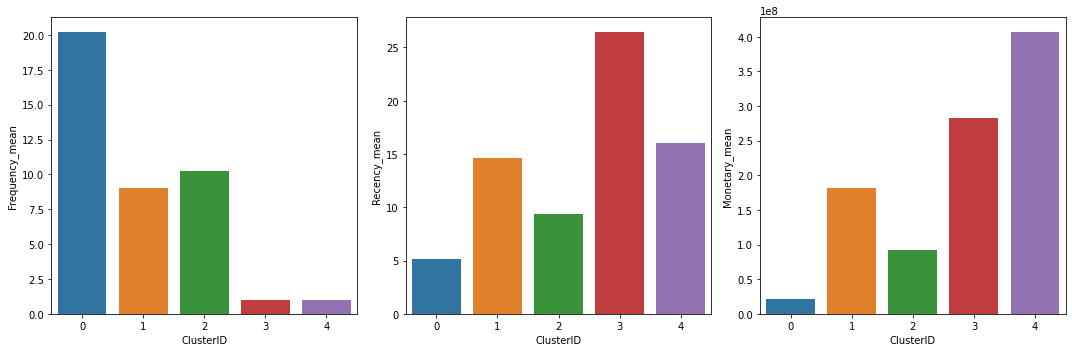

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df.ClusterID, y=df.Frequency_mean, ax = axs[0])
sns.barplot(x=df.ClusterID, y=df.Recency_mean, ax = axs[1])
sns.barplot(x=df.ClusterID, y=df.Monetary_mean, ax = axs[2])
plt.tight_layout()            
plt.show()